In [26]:
import numpy as np
import matplotlib.pyplot as plt


In [27]:
class PIController:
    def __init__(self, kp, ki, dt):
        self.kp = kp
        self.ki = ki
        self.dt = dt
        self.integral = 0

    def control(self, error):
        self.integral += error * self.dt
        output = self.kp * error + self.ki * self.integral
        return output
    
class InductionMotor:
    def __init__(self, r_s, l_s, t_r, j, dt):
        self.r_s = r_s  # Stator resistance
        self.l_s = l_s  # Stator inductance
        self.t_r = t_r  # Rotor time constant
        self.j = j      # Rotor inertia
        self.dt = dt
        self.i_s_d = 0  # d-axis stator current
        self.i_s_q = 0  # q-axis stator current
        self.psi_r_d = 0  # d-axis rotor flux
        self.psi_r_q = 0  # q-axis rotor flux
        self.omega = 0  # Rotor speed

    def update_currents(self, v_d, v_q):
        # Update rotor fluxes
        d_psi_r_d = v_d - self.r_s * self.i_s_d
        d_psi_r_q = v_q - self.r_s * self.i_s_q
        self.psi_r_d += d_psi_r_d * self.dt
        self.psi_r_q += d_psi_r_q * self.dt
        
        # Update stator currents
        di_s_d = (v_d - self.r_s * self.i_s_d - self.psi_r_d / self.t_r) / self.l_s
        di_s_q = (v_q - self.r_s * self.i_s_q - self.psi_r_q / self.t_r) / self.l_s
        self.i_s_d += di_s_d * self.dt
        self.i_s_q += di_s_q * self.dt
        
        return self.i_s_d, self.i_s_q

    def update_speed(self, torque):
        # Update rotor speed
        d_omega = torque / self.j
        self.omega += d_omega * self.dt
        return self.omega

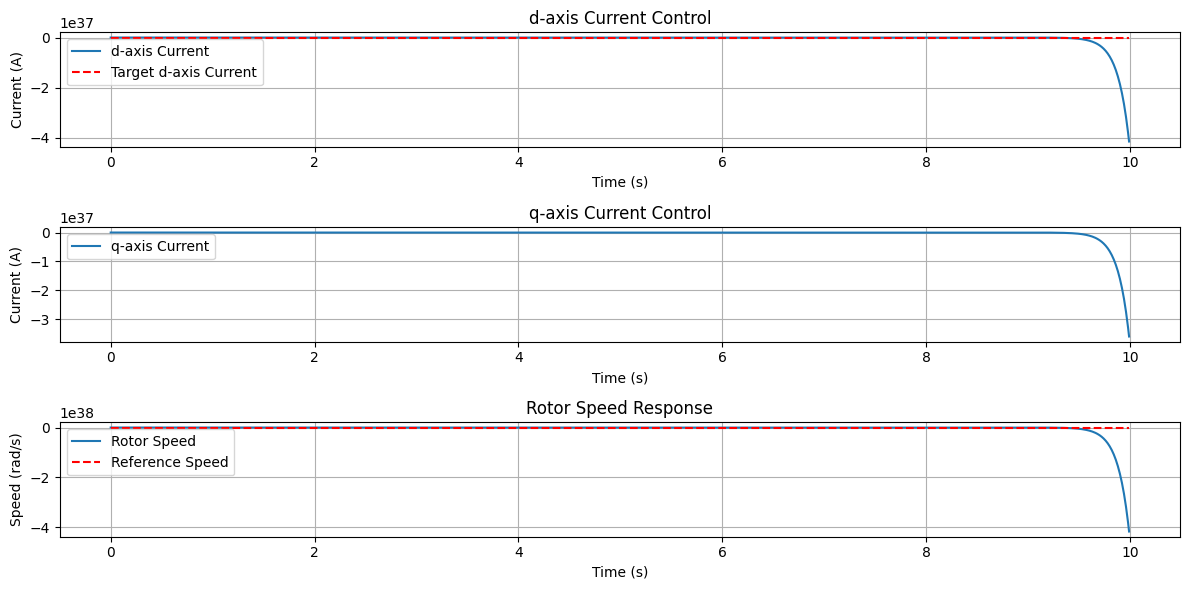

In [30]:
# Define motor parameters
r_s = 0.5  # Stator resistance (Ohm)
l_s = 0.01 # Stator inductance (H)
t_r = 0.1  # Rotor time constant (s)
j = 0.01   # Rotor inertia (kg.m^2)
dt = 0.01  # Time step (s)

# Create motor and PI controller instances
motor = InductionMotor(r_s, l_s, t_r, j, dt)
pi_d_controller = PIController(kp = 0.05, ki = 0.01, dt=dt)
pi_q_controller = PIController(kp = 0.05, ki = 0.01, dt=dt)
pi_speed_controller = PIController(kp=0.05, ki=0.01, dt=dt)  # Speed PI controller

# Set target d-axis current and reference speed
target_d_current = 5.0
reference_speed = 50.0  # rad/s
time = np.arange(0, 10, dt)

# Initial conditions
d_current_list = []
q_current_list = []
speed_list = []

# Simulate the system
for t in time:
    # Speed control
    speed_error = reference_speed - motor.omega
    target_q_current = pi_speed_controller.control(speed_error)  # Adjust q-axis current based on speed error
    
    # Current control
    error_d = target_d_current - motor.i_s_d
    error_q = target_q_current - motor.i_s_q
    
    control_signal_d = pi_d_controller.control(error_d)
    control_signal_q = pi_q_controller.control(error_q)
    
    motor_d_current, motor_q_current = motor.update_currents(control_signal_d, control_signal_q)
    
    torque = motor_q_current  # Simplified torque calculation
    speed = motor.update_speed(torque)
    
    d_current_list.append(motor_d_current)
    q_current_list.append(motor_q_current)
    speed_list.append(speed)

# Convert lists to numpy arrays for plotting
d_current_list = np.array(d_current_list)
q_current_list = np.array(q_current_list)
speed_list = np.array(speed_list)

# Plot results
plt.figure(figsize=(12, 6))

plt.subplot(3, 1, 1)
plt.plot(time, d_current_list, label='d-axis Current')
plt.plot(time, [target_d_current]*len(time), 'r--', label='Target d-axis Current')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title('d-axis Current Control')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 2)
plt.plot(time, q_current_list, label='q-axis Current')
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title('q-axis Current Control')
plt.legend()
plt.grid(True)

plt.subplot(3, 1, 3)
plt.plot(time, speed_list, label='Rotor Speed')
plt.plot(time, [reference_speed]*len(time), 'r--', label='Reference Speed')
plt.xlabel('Time (s)')
plt.ylabel('Speed (rad/s)')
plt.title('Rotor Speed Response')
plt.legend()
plt.grid(True)

plt.tight_layout()
